In [1]:
## Requires condaScanpy1_6_0.yaml

import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import scvelo as scv
import glob
import os

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scv.settings.set_figure_params('scvelo', color_map='cividis')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
anndata             0.7.5
backcall            0.1.0
cairo               1.19.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
igraph              0.8.0
importlib_metadata  1.5.0
ipykernel           5.1.4
ipython_genutils    0.2.0
jedi                0.16.0
joblib              0.14.1
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.7.0
llvmlite            0.31.0
matplotlib          3.2.1
mpl_toolkits        NA
natsort             7.1.0
numba               0.48.0
numexpr             2.7.2
numpy               1.18.1
packaging           20.8
pandas              1.1.2
parso               0.6.2
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.3
ptyprocess          0.6.0
pygments            2.6.1
pyparsing           2.4.6
pytz

In [2]:
samples = ['CD4-Cre','Lean','Obese','PPARgTKO']
## Path to cellranger output directories
h5_loc = 'CM_AM_05/'

## Load Cellranger Outputs

In [3]:
infile = samples.pop(0)
h5 = h5_loc + infile + '_analysis/outs/filtered_feature_bc_matrix.h5'

bdata = sc.read_10x_h5(h5)
bdata.X = bdata.X.toarray()

bdata.obs['sample'] = [infile]*bdata.n_obs
bdata.var_names_make_unique()
bdata.obs_names_make_unique()

bdata
print(bdata.obs['sample'].value_counts())
print(samples)

reading /wynton/group/ye/cody/marsonlab/sagar/data/CM_AM_05/CD4-Cre_analysis/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2469 × 31053
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

CD4-Cre    2469
Name: sample, dtype: int64
['Lean', 'Obese', 'PPARgTKO']


In [4]:
## Preserve bdata to avoid having to run above cell every time
adata = bdata

## Loop through samples
for i in range(len(samples)):
    infile = samples[i]
#     geno = infile[0:2]
#     condition = infile[3:]
    h5 = h5_loc + infile + '_analysis/outs/filtered_feature_bc_matrix.h5'

    bdata_tmp = sc.read_10x_h5(h5)
    bdata_tmp.X = bdata_tmp.X.toarray()

    bdata_tmp.obs['sample'] = [infile]*bdata_tmp.n_obs
#     bdata_tmp.obs['geno'] = [geno]*bdata_tmp.n_obs
#     bdata_tmp.obs['condition'] = [condition]*bdata_tmp.n_obs
    bdata_tmp.var_names_make_unique()
    bdata_tmp.obs_names_make_unique()

    print(bdata_tmp.obs['sample'].value_counts())
    bdata_tmp
    
    ## Concatenate to main bdata object
    adata = adata.concatenate(bdata_tmp)
    #adata.var['gene_ids'] = adata.var['gene_ids-1']
    #adata.var.drop(columns = ['gene_ids-1', 'gene_ids-0'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

reading /wynton/group/ye/cody/marsonlab/sagar/data/CM_AM_05/Lean_analysis/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Lean    2814
Name: sample, dtype: int64


AnnData object with n_obs × n_vars = 2814 × 31053
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

reading /wynton/group/ye/cody/marsonlab/sagar/data/CM_AM_05/Obese_analysis/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Obese    4589
Name: sample, dtype: int64


AnnData object with n_obs × n_vars = 4589 × 31053
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

reading /wynton/group/ye/cody/marsonlab/sagar/data/CM_AM_05/PPARgTKO_analysis/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


PPARgTKO    2725
Name: sample, dtype: int64


AnnData object with n_obs × n_vars = 2725 × 31053
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
print(adata.obs['sample'].value_counts())
print('')

adata

Obese       4589
Lean        2814
PPARgTKO    2725
CD4-Cre     2469
Name: sample, dtype: int64



AnnData object with n_obs × n_vars = 12597 × 31053
    obs: 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

## Process Merged Anndata

filtered out 186 cells that have less than 200 genes expressed
filtered out 14604 genes that are detected in less than 3 cells


... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


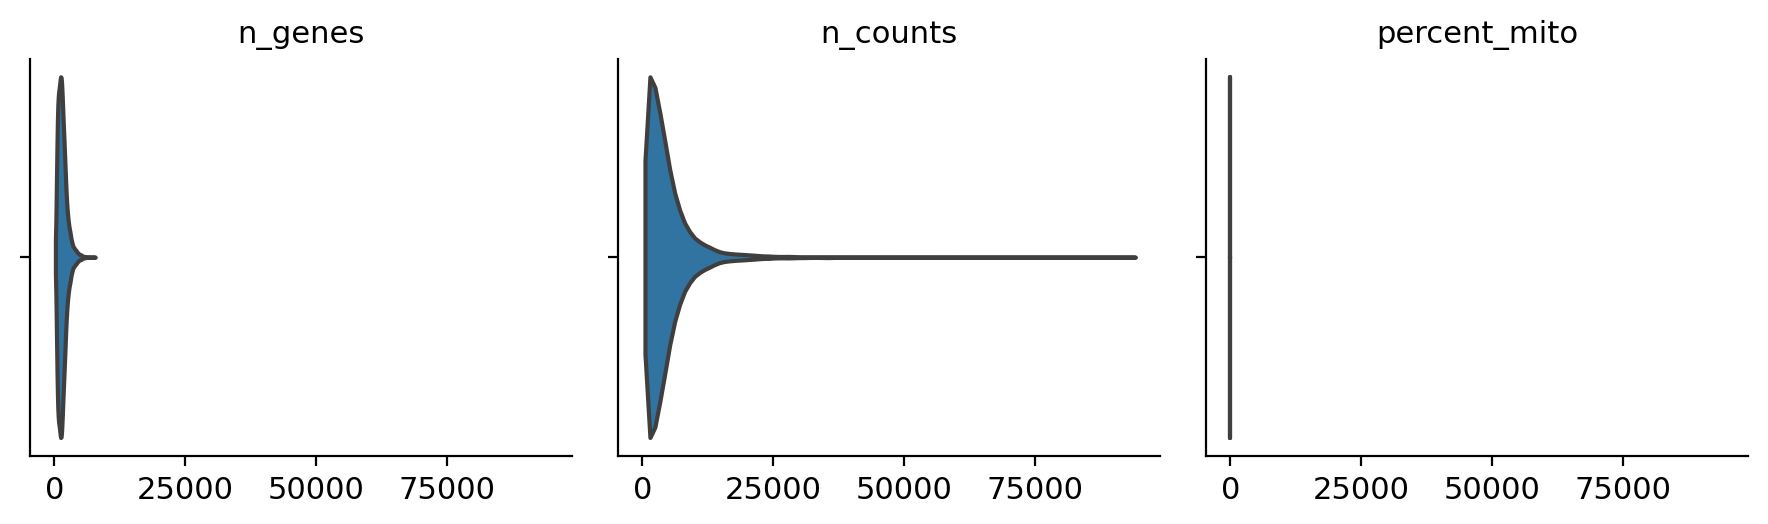

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=1)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_genes(adata, min_counts=1)


adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['percent_mito'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

sc.pl.violin(adata, keys=['n_genes', 'n_counts', 'percent_mito'], size=0, multi_panel=True)

In [7]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [8]:
adata = adata[adata.obs.n_genes < 6000, :]
adata = adata[adata.obs.percent_mito < 0.25, :]

In [9]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [10]:
'Cd4' in adata.var_names

True

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


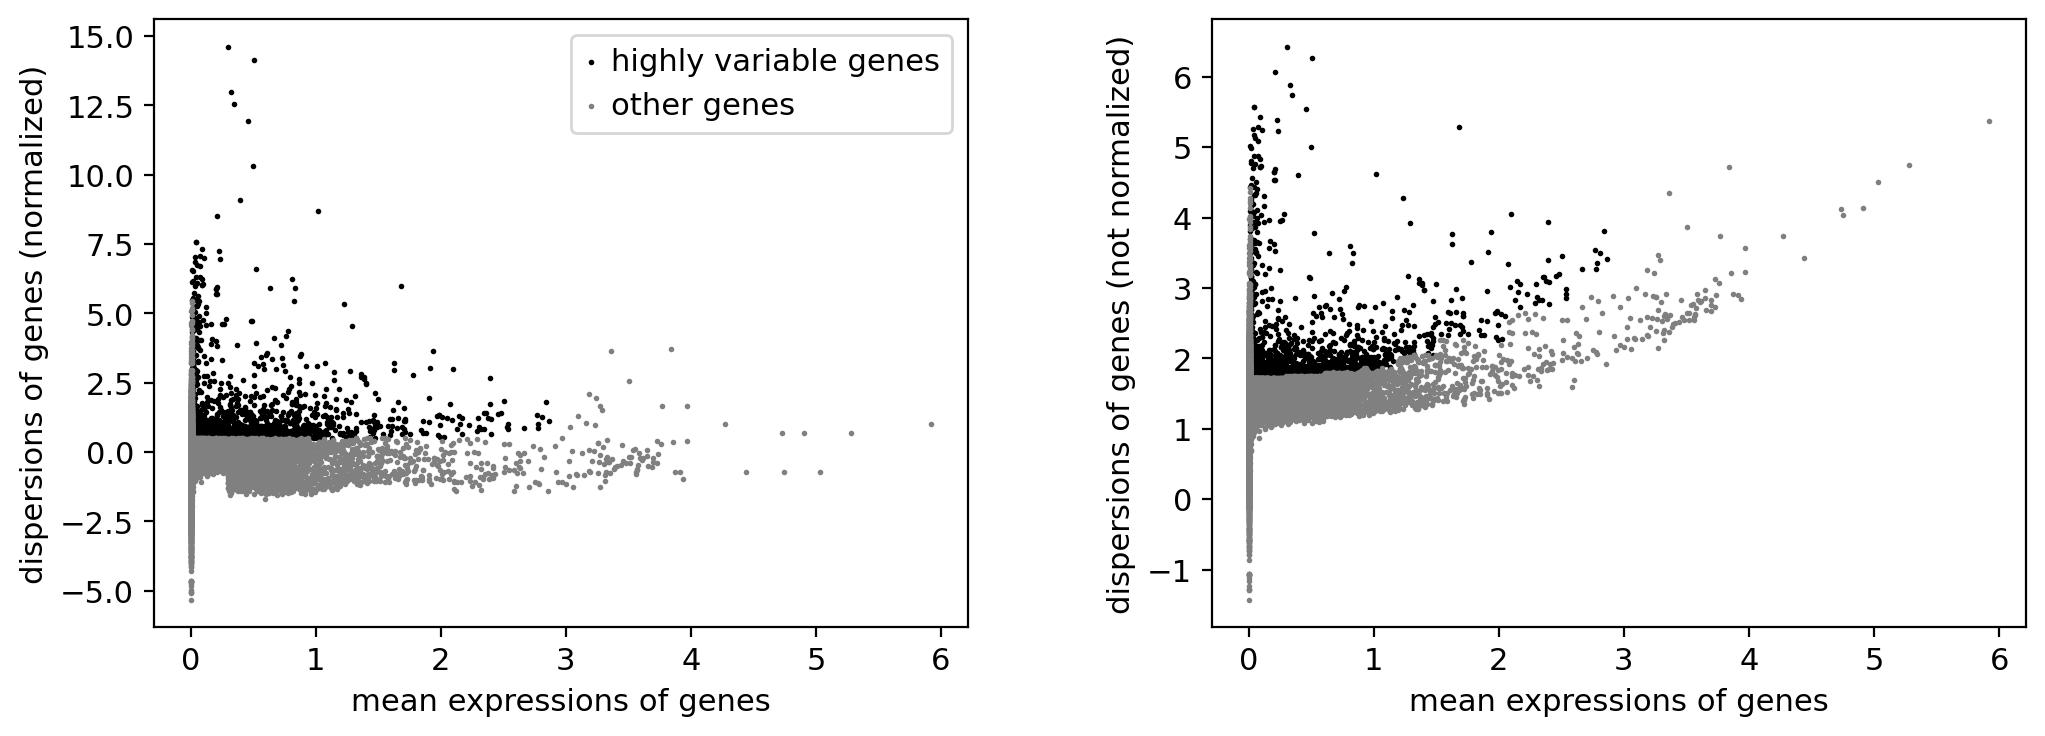

In [11]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [12]:
adata
print('')
print(adata.obs['sample'].value_counts())

AnnData object with n_obs × n_vars = 12034 × 16449
    obs: 'sample', 'batch', 'n_genes', 'n_counts', 'log_counts', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


Obese       4365
Lean        2736
PPARgTKO    2592
CD4-Cre     2341
Name: sample, dtype: int64


In [13]:
print(np.any(adata.X.sum(axis=0) == 0))
print(np.any(adata.X.sum(axis=1) == 0))

True
False


In [14]:
adata = adata[:,adata.X.sum(axis=0) > 0].copy()

In [15]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    finished (0:03:14)


In [16]:
sc.pp.scale(adata, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


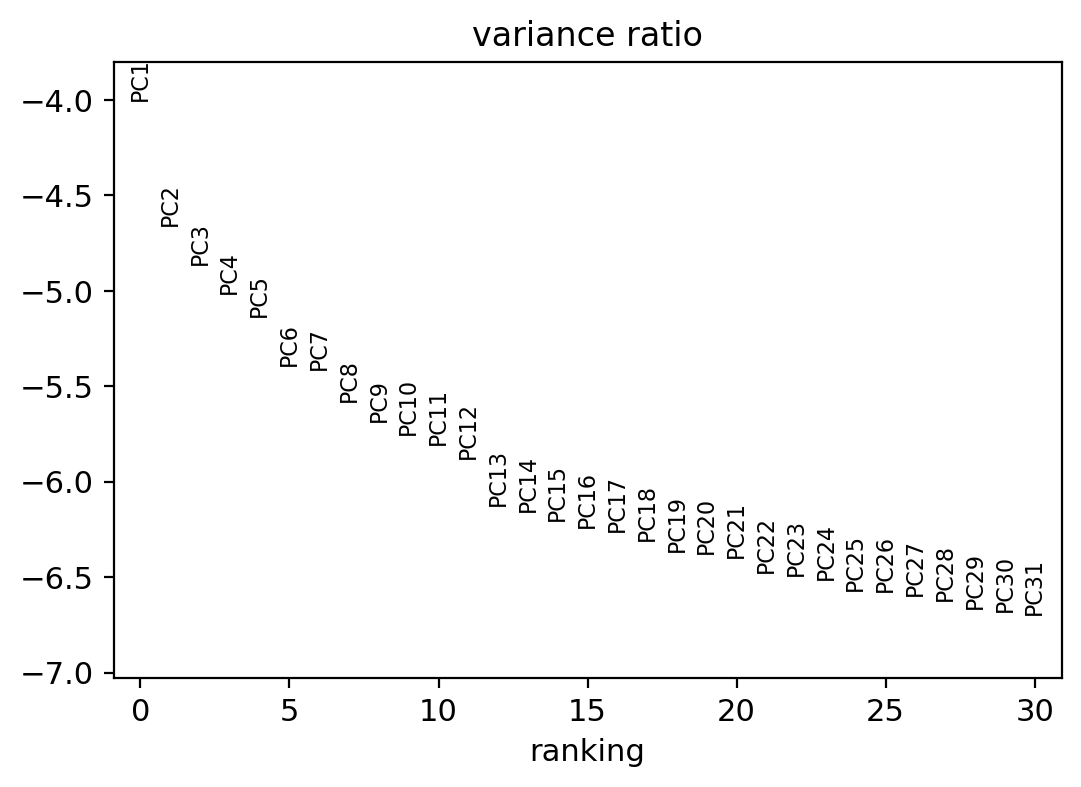

In [17]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

## Dimensionality Reduction & Clustering

In [18]:
adata

AnnData object with n_obs × n_vars = 12034 × 16445
    obs: 'sample', 'batch', 'n_genes', 'n_counts', 'log_counts', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [19]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20, random_state=1)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


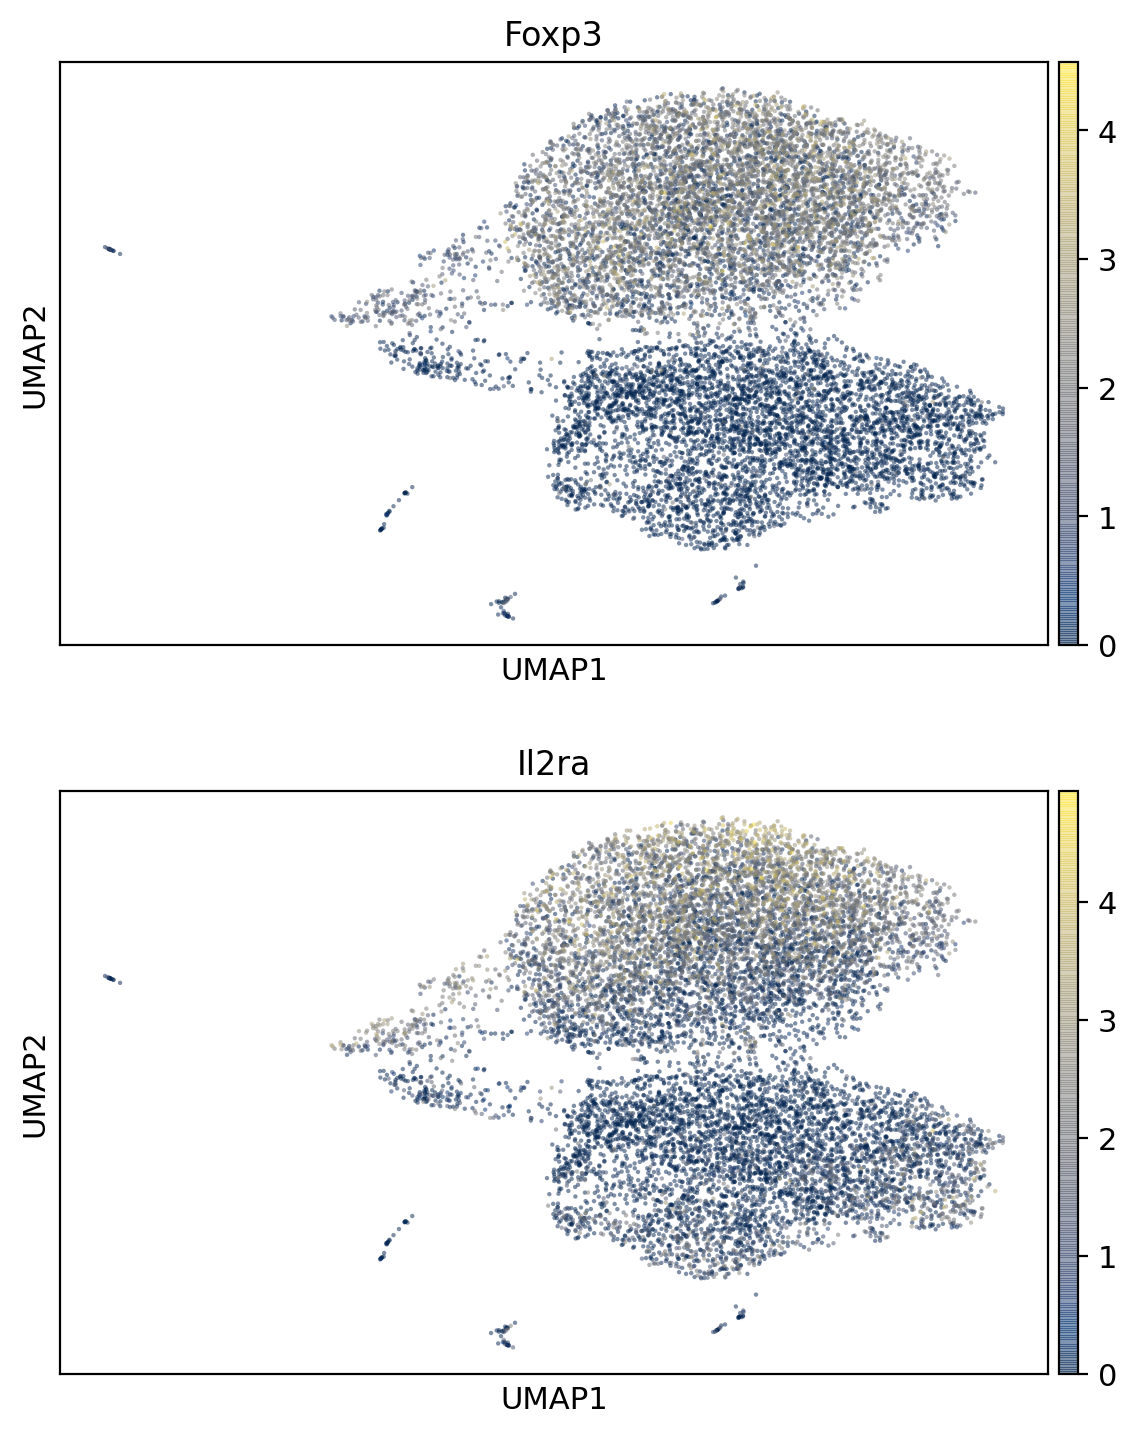

In [20]:
sc.pl.umap(adata, color=['sample'], ncols=1, alpha=0.5)
sc.pl.umap(adata, color=['Foxp3','Il2ra'], ncols=1, alpha=0.5)

In [21]:
sc.tl.leiden(adata, resolution = 0.25)

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


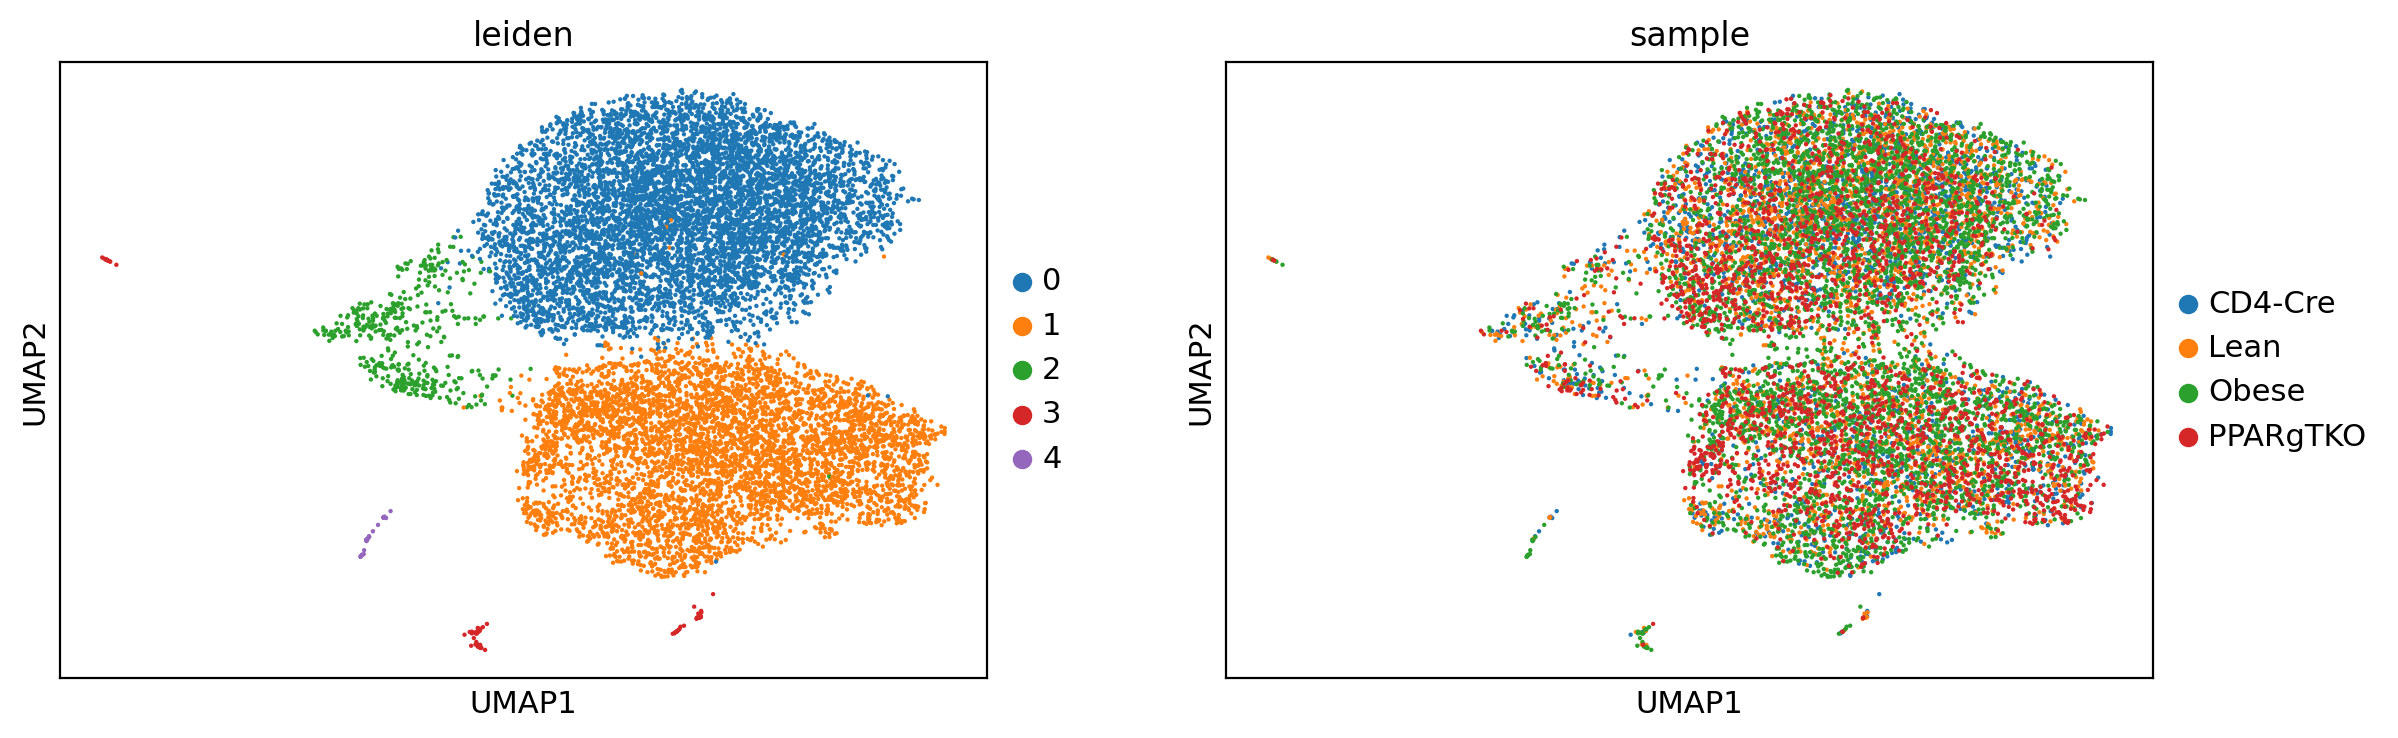

In [22]:
sc.pl.umap(adata, color=['leiden','sample'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:26)


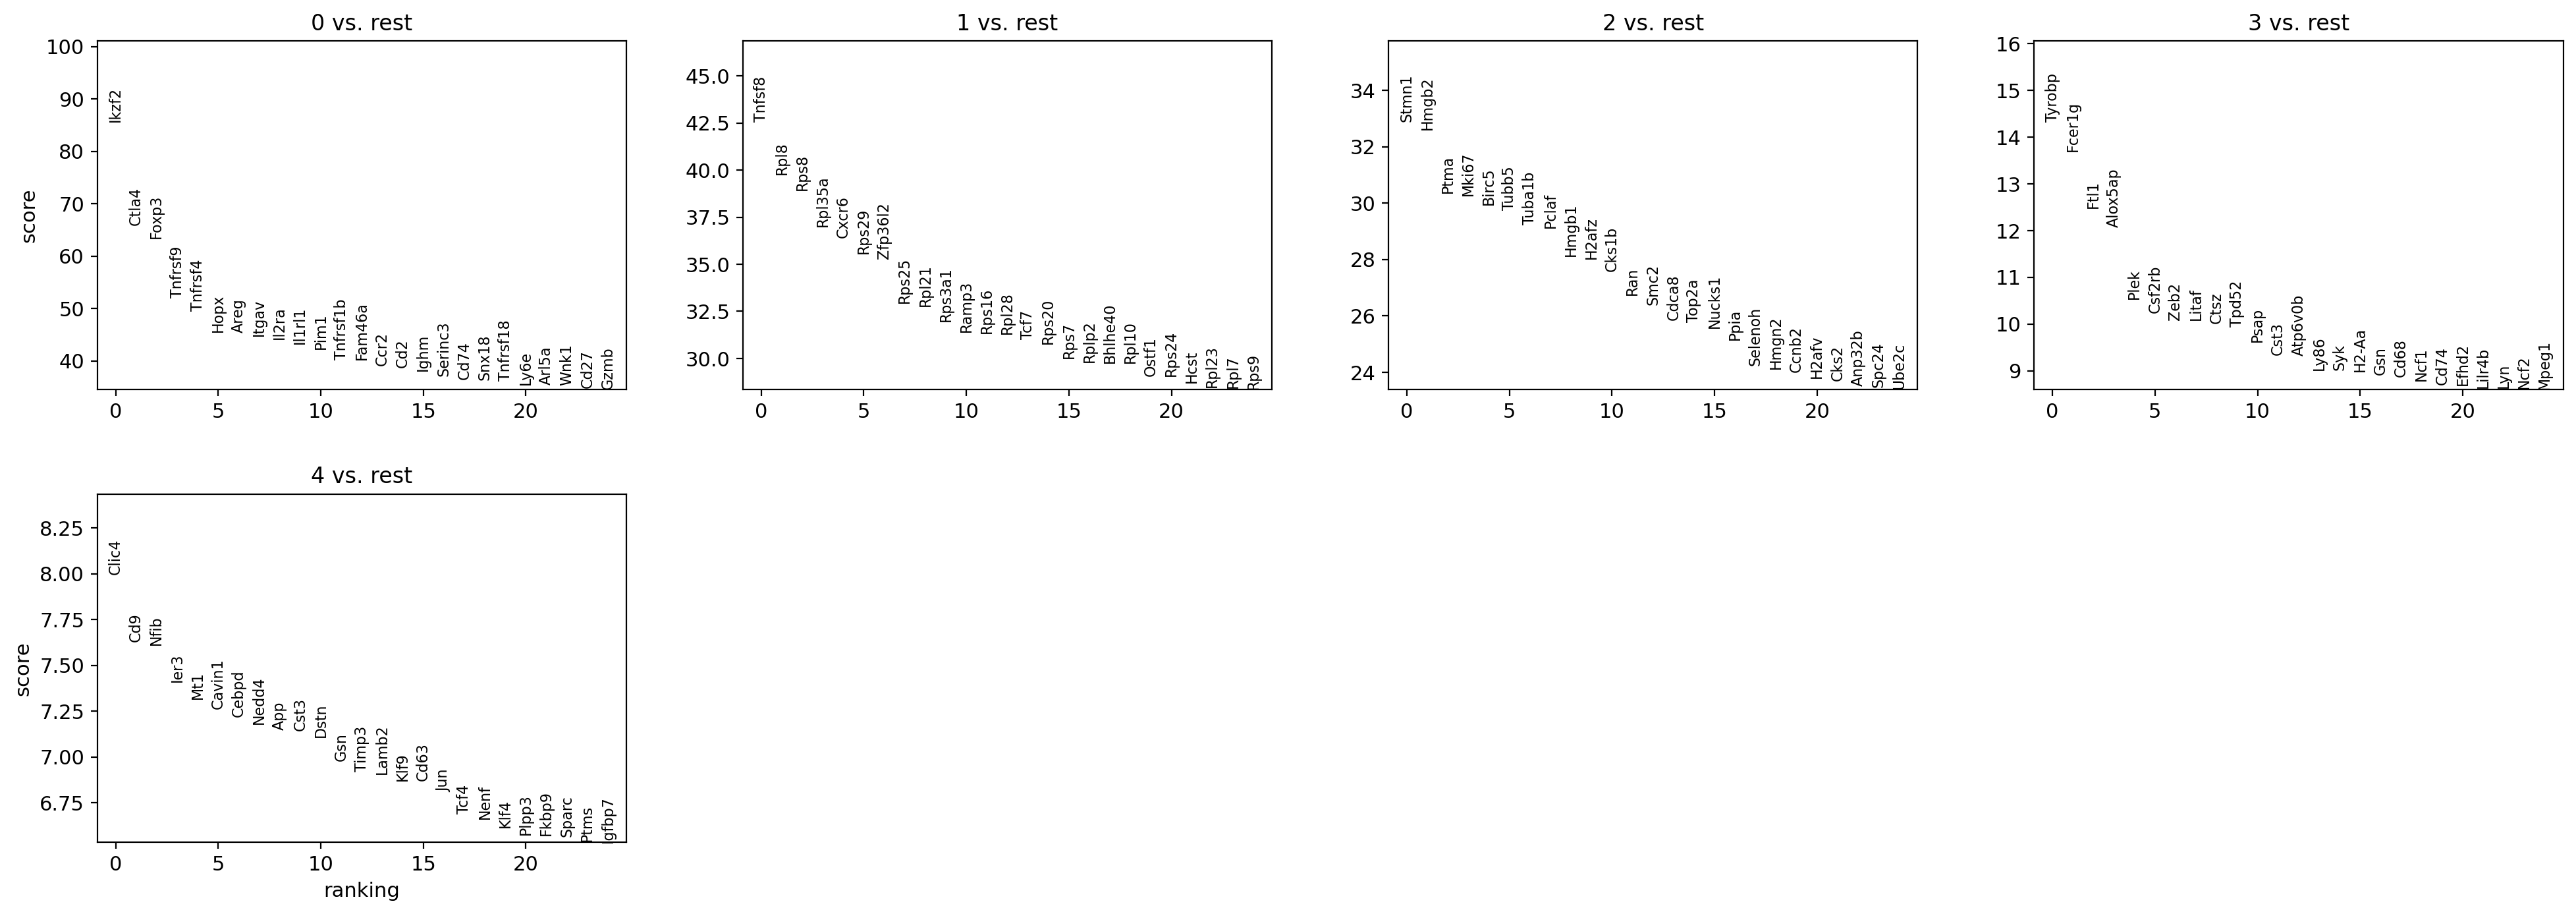

0        1        2        3       4
0      Ikzf2   Tnfsf8    Stmn1   Tyrobp   Clic4
1      Ctla4     Rpl8    Hmgb2   Fcer1g     Cd9
2      Foxp3     Rps8     Ptma     Ftl1    Nfib
3    Tnfrsf9   Rpl35a    Mki67  Alox5ap    Ier3
4    Tnfrsf4    Cxcr6    Birc5     Plek     Mt1
5       Hopx    Rps29    Tubb5   Csf2rb  Cavin1
6       Areg  Zfp36l2   Tuba1b     Zeb2   Cebpd
7      Itgav    Rps25    Pclaf    Litaf   Nedd4
8      Il2ra    Rpl21    Hmgb1     Ctsz     App
9     Il1rl1   Rps3a1    H2afz    Tpd52    Cst3
10      Pim1    Ramp3    Cks1b     Psap    Dstn
11  Tnfrsf1b    Rps16      Ran     Cst3     Gsn
12    Fam46a    Rpl28     Smc2  Atp6v0b   Timp3
13      Ccr2     Tcf7    Cdca8     Ly86   Lamb2
14       Cd2    Rps20    Top2a      Syk    Klf9
15      Ighm     Rps7   Nucks1    H2-Aa    Cd63
16   Serinc3    Rplp2     Ppia      Gsn     Jun
17      Cd74  Bhlhe40  Selenoh     Cd68    Tcf4
18     Snx18    Rpl10    Hmgn2     Ncf1    Nenf
19  Tnfrsf18    Ostf1    Ccnb2     Cd74    Klf4

In [23]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

## Remove APC clusters & recluster Leiden

In [24]:
remove=['3','4']
filt = adata[~adata.obs['leiden'].isin(remove)]
sc.tl.leiden(filt, resolution=1, key_added='leiden_r1')
sc.tl.leiden(filt, resolution=0.9, key_added='leiden_r0.9')

running Leiden clustering


Trying to set attribute `.obs` of view, copying.


    finished: found 13 clusters and added
    'leiden_r1', the cluster labels (adata.obs, categorical) (0:00:09)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_r0.9', the cluster labels (adata.obs, categorical) (0:00:03)


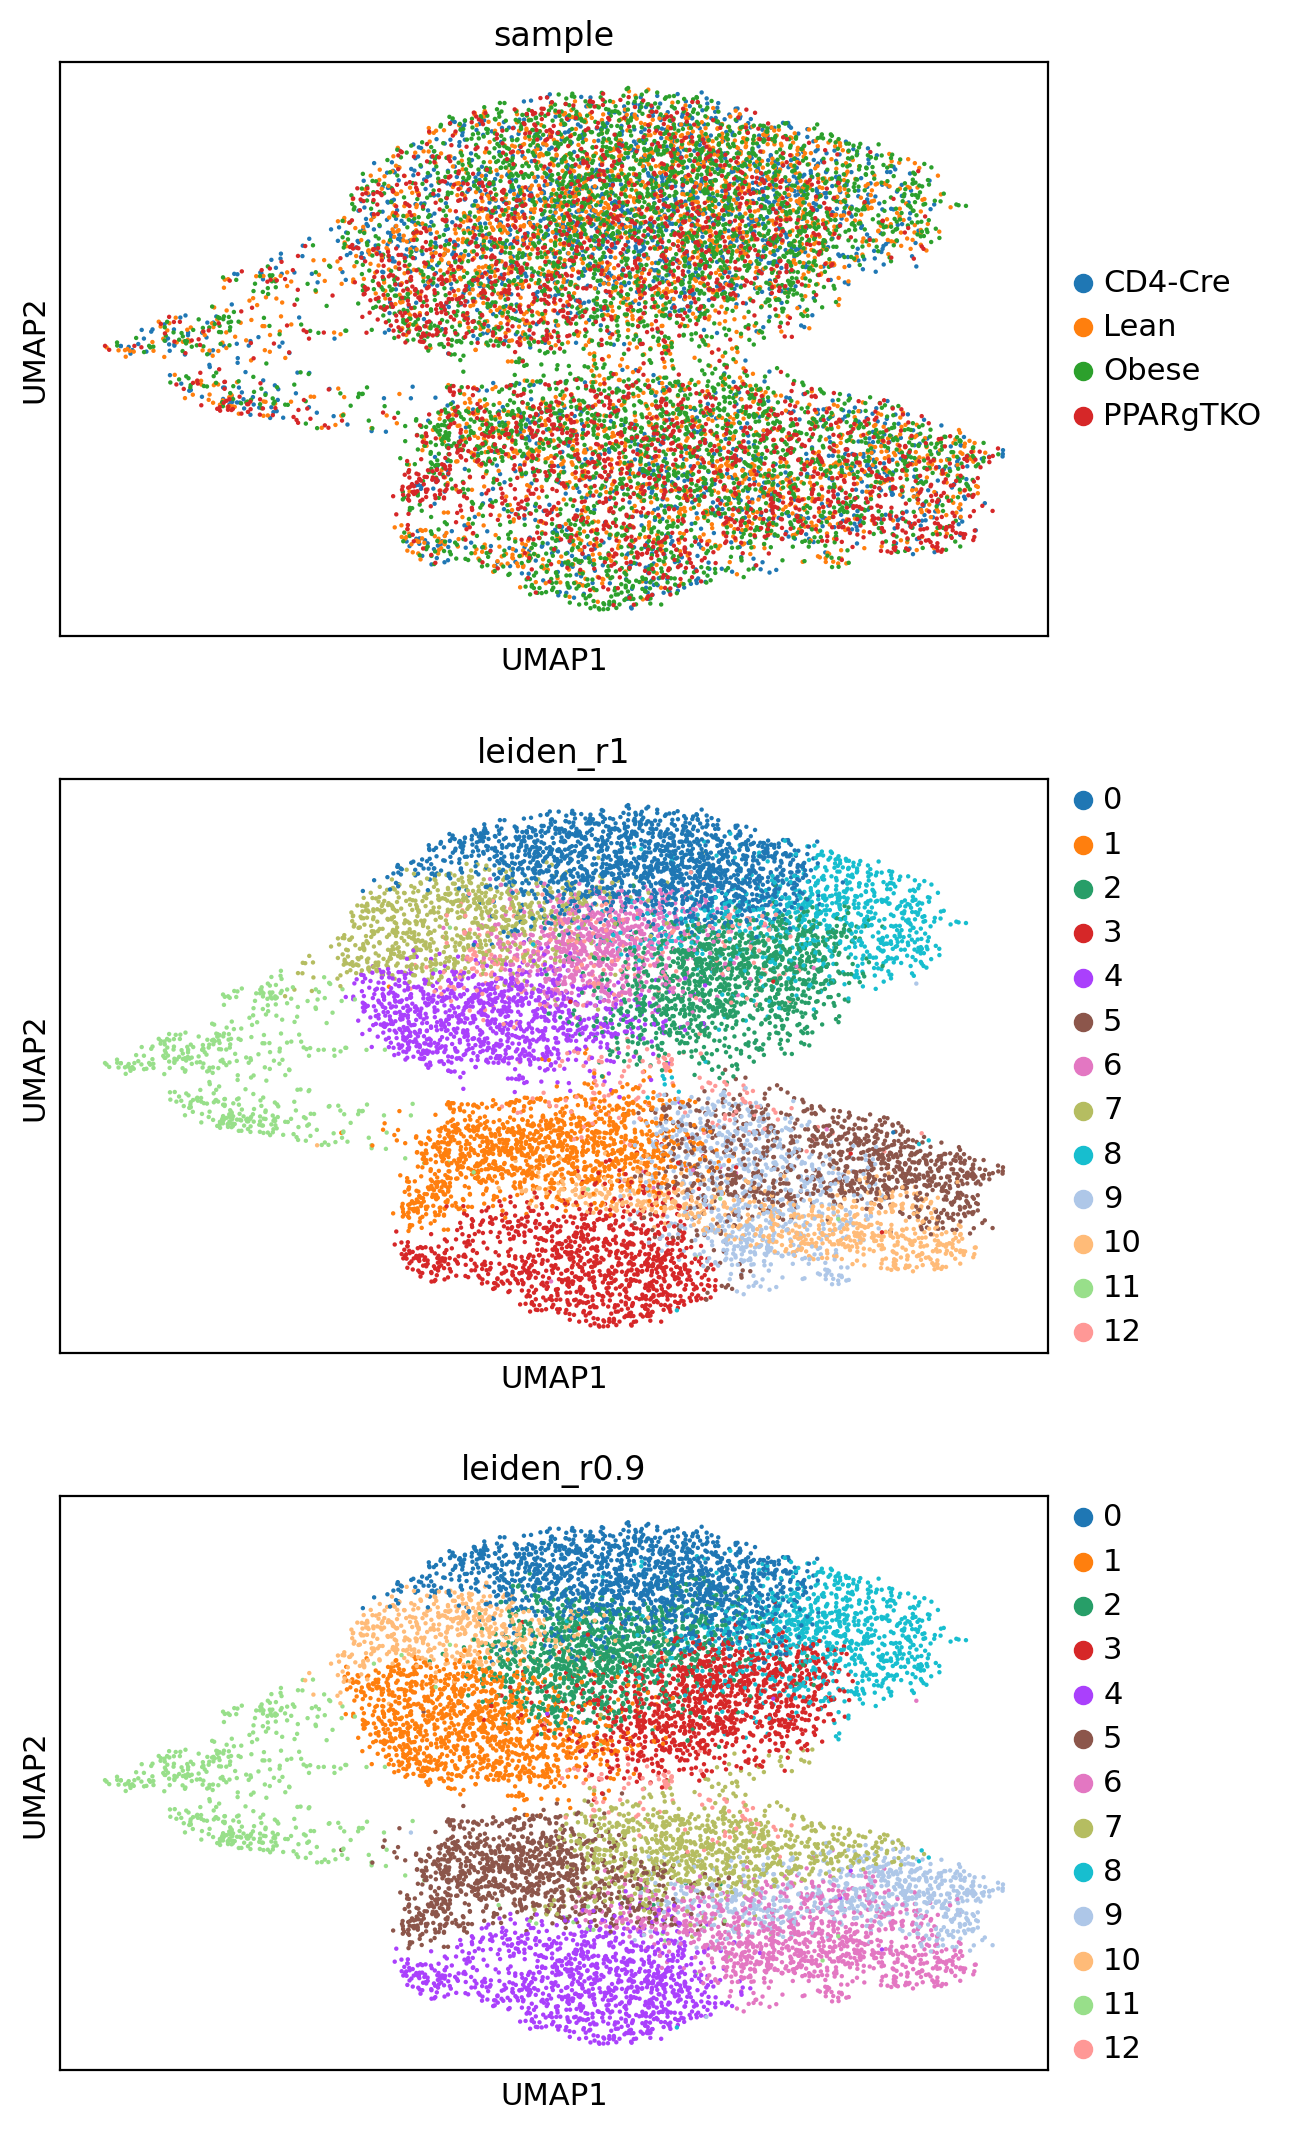

In [25]:
sc.pl.umap(filt, color=['sample','leiden_r1','leiden_r0.9'], ncols=1)

In [26]:
filt

AnnData object with n_obs × n_vars = 11938 × 16445
    obs: 'sample', 'batch', 'n_genes', 'n_counts', 'log_counts', 'percent_mito', 'leiden', 'leiden_r1', 'leiden_r0.9'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'leiden_r1_colors', 'leiden_r0.9_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [27]:
filt.write('Fig1_2_filteredGEX.h5ad')